---
# Create graphic for Vessel Time Exposures and comparing oil spills files
---

The monte carlo runs were completed on Compute Canada's supercomputer, `Graham` and this code is intended to be used on that system.  It requires initialization of a Virtual Environment.  See `/home/rmueller/projects/def-allen/rmueller/graham-jupyter-env.txt`.

First initiate a compute node (no heavy-lifting in this example) with: 
```
salloc --time=1:00:00 --ntasks=1 --cpus-per-task=1 --mem-per-cpu=1024M --account=rrg-allen
```
Activate `VENV` with:
```
module load python/3.8.2
source ~/venvs/jupyter/bin/activate
```
Deactivate `VENV` with:
```
deactivate
```
If the `jupyter` `VENV` is not yet setup, install it with:
```
module load python/3.8.2
python3 -m virtualenv --no-download ~/venvs/jupyter
source ~/venvs/jupyter/bin/activate
python3 -m pip install --no-index --upgrade pip
python3 -m pip install -r /home/rmueller/projects/def-allen/rmueller/graham-jupyter-env.txt
```

This environment is setup to allow user to initiate a remote window using:
```
jupyter lab --no-browser --ip $(hostname -f)
```

In [1]:
import os
import numpy
import pandas
import xarray
import netCDF4 as nc
import cartopy.crs
import cmocean
from glob import glob
from cartopy import feature
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
#from salishsea_tools import geo_tools, tidetools

In [2]:
ssc_bathymetry = '/ocean/rmueller/SalishSeaCast/grid/bathymetry_201702.nc'
ssc_mask = '/ocean/rmueller/SalishSeaCast/grid/mesh_mask201702.nc'

fnames = [
    'Lagrangian_akns.dat',
    'Lagrangian_bunker.dat',
    'Lagrangian_dilbit.dat',
    'Lagrangian_diesel.dat',
    'Lagrangian_gas.dat',
    'Lagrangian_jet.dat',
    'Lagrangian_other.dat'
]
MIDOSSlabels=[
    'ANS',
    'Bunker-C',
    'Dilbit',
    'Diesel',
    'Diesel',
    'Diesel',
    'Bunker-C'
]

### Load 10,000 spills files on Salish

In [3]:
spills_dir_name = 'spill_files_091921'
# On Salish
data_directory = Path(f'/ocean/rmueller/MIDOSS/{spills_dir_name}')
graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics/MEOPAR_ASM_2022')
# Load Oil Attribution file 
oil_attribution_file = '/data/MIDOSS/marine_transport_data/oil_attribution.yaml'
# create list of spill files to plot/evaluate
filenames = sorted(glob(os.path.join(data_directory,"*.csv")))

In [4]:
df={}
for index,fn in enumerate(filenames):
    print(index,fn)
    df[index] = pandas.read_csv(fn)
    # rename lagrangian files as oil types (for plotting)
    df[index]['Lagrangian_template'] = df[index]['Lagrangian_template'].replace(
         fnames, MIDOSSlabels
    )
    if index == 0:
        df_combined = df[index].copy()
    else:
        df_combined = pandas.concat([df_combined, df[index]])
    

0 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_1.csv
1 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_2.csv
2 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_3.csv
3 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_4.csv
4 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_5.csv
5 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_6.csv
6 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_7.csv
7 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_8.csv
8 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_9.csv


In [5]:
[*df]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [6]:
# load SSC grid and mask
bathy = xarray.open_dataset(ssc_bathymetry)
mask = xarray.open_dataset(ssc_mask)
# create mask for plotting...?
tmask = mask.tmask[0,0,:,:]

In [7]:
a_count={}
a_vol = {}

### Bin spills by number of spills and volume of spills for each 10,000 spills file

In [8]:
for index,fn in enumerate(filenames):
    print(index)
    # histogram by number of spills
    h_count,xe,ye = numpy.histogram2d(
        df[index].spill_lon, 
        df[index].spill_lat, 
        bins=100
    );
    # historgram by spill volume
    h_vol,xe,ye = numpy.histogram2d(
        df[index].spill_lon, 
        df[index].spill_lat, 
        weights = df[index].spill_volume,
        bins=100
    );
    # combine histrograms into 3D arrays
    a_count[index]=h_count
    a_vol[index]=h_vol
    if index == 0:
        count_hist_3d = a_count[0]
        vol_hist_3d = a_vol[0]
    else:
        count_hist_3d=numpy.dstack([count_hist_3d,h_count])
        vol_hist_3d=numpy.dstack([vol_hist_3d,h_vol])


0
1
2
3
4
5
6
7
8


In [9]:
count_hist_3d.shape

(100, 100, 9)

### Create 2d array with range of values across 10,000 spills files of:
- number of spills per histogram cell
- volume of oil spilled in histogram cells

In [10]:
count_hist_range = count_hist_3d.max(axis=2) - count_hist_3d.min(axis=2)
vol_hist_range = vol_hist_3d.max(axis=2) - vol_hist_3d.min(axis=2)

In [11]:
count_hist_range.shape

(100, 100)

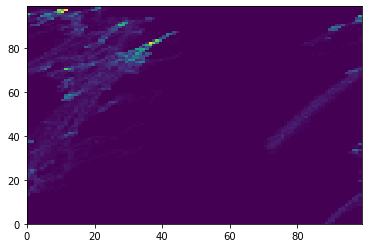

In [13]:
# ax = fig.add_subplot(132, title='pcolormesh: actual edges',
#         aspect='equal')
# xc = (xe[:-1] + xe[1:]) / 2
# yc = (ye[:-1] + ye[1:]) / 2
# X, Y = numpy.meshgrid(xc, yc)
plt.pcolormesh(count_hist_range,shading='nearest')
plt.show()

/tmp/ipykernel_20345/539989034.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(bathy.nav_lon, bathy.nav_lat, bathy.Bathymetry, cmap='Greys', alpha=.1)


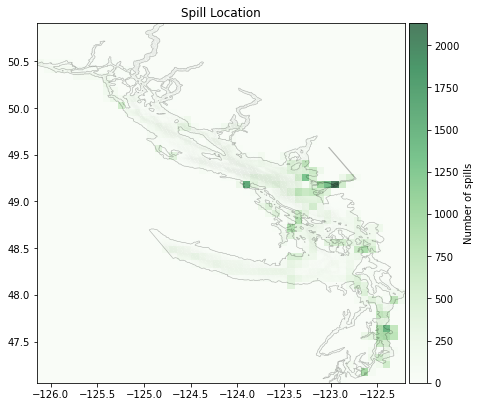

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.pcolormesh(
    bathy.nav_lon, 
    bathy.nav_lat, 
    bathy.Bathymetry, cmap='Greys', alpha=.1)
ax.contour(
    bathy.nav_lon, 
    bathy.nav_lat,
    tmask, alpha=0.05,colors='k',linewidths =.5)

h = ax.hist2d(
    df_combined.spill_lon, 
    df_combined.spill_lat, 
    alpha=0.7, cmap='Greens', bins=50);
ax.set_aspect(1)
ax.set_title('Spill Location');
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(h[3], cax=cax)
cb.set_label('Number of spills')